In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
data = pd.read_excel('data.xlsx')

In [36]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%y-%m-%d %H') # 显式指定日期时间格式
data['timestamp'] = data['datetime'].astype('int64') // 10**9

In [37]:
features = ['T', 'Po', 'P', 'timestamp']  # 只保留 T
target = 'U'

In [38]:
if data[features].isnull().any().any():
    print("Warning: Missing values found in features. Imputing with mean.")
    data[features] = data[features].fillna(data[features].mean())

if data[target].isnull().any():
    print("Warning: Missing values found in target. Imputing with mean.")
    data[target] = data[target].fillna(data[target].mean())

In [39]:
X = data[features].values
y = data[target].values.reshape(-1, 1)


X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [40]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length + 1

    def __getitem__(self, idx):
        return self.X[idx:idx+self.seq_length], self.y[idx+self.seq_length-1]

seq_length = 24  # 使用过去24小时的数据来预测
dataset = WeatherDataset(X_scaled, y_scaled, seq_length)


In [41]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化 hidden state 和 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # 前向传播 LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # 获取最后一个时间步的输出
        out = out[:, -1, :]

        # 解码 hidden state
        out = self.fc(out)
        return out

In [43]:
input_size = len(features)  # 修改 input_size
hidden_size = 50
output_size = 1
num_layers = 2
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

In [44]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

num_epochs = 20
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

print("Finished Training")

Finished Training


In [45]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += loss_fn(outputs, targets).item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0178


In [46]:
sample_size = 100
sample_X = torch.tensor(X_scaled[:seq_length+sample_size], dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_scaled = []
    for i in range(sample_size):
        output = model(sample_X[:, i:i+seq_length])
        predicted_scaled.append(output.item())

predicted = y_scaler.inverse_transform(np.array(predicted_scaled).reshape(-1, 1))

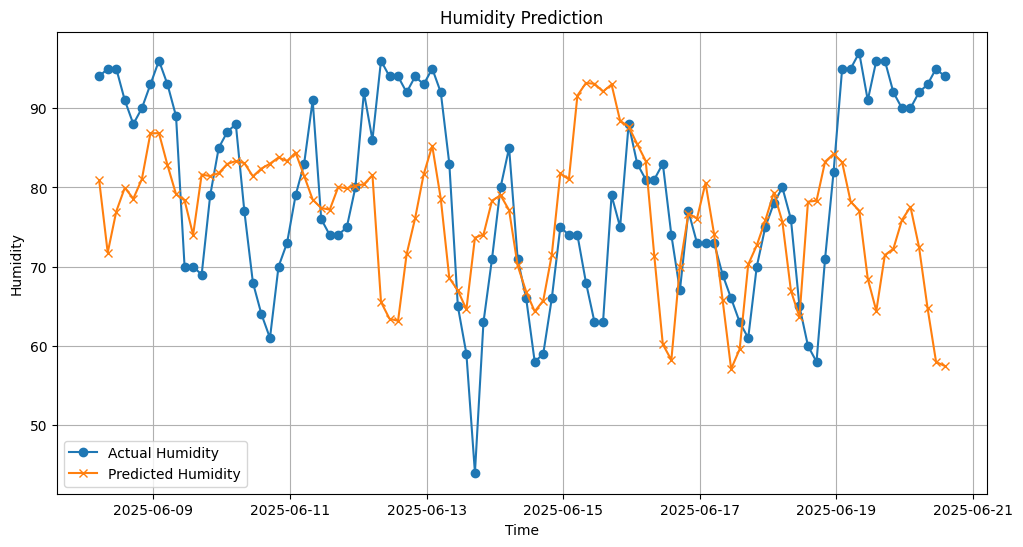

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'][seq_length:seq_length+sample_size], y[:sample_size], label='Actual Humidity', marker='o')
plt.plot(data['datetime'][seq_length:seq_length+sample_size], predicted, label='Predicted Humidity', marker='x')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Humidity Prediction')
plt.legend()
plt.grid(True)
plt.show()